In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv("data.csv")

# Printing the dataset
print(df.head())

   PRODUCT_ID  MONTH  UNIT_SALES PRODUCT_NAME  SUPPLY_TIME  QUANTITY_ON_HAND
0           1      1       14700  Berry Juice            3                11
1           1      2        7980  Berry Juice            3                30
2           1      3        7980  Berry Juice            3                20
3           1      4        6300  Berry Juice            3                15
4           1      5        3780  Berry Juice            3                44


In [ ]:
print(df.to_string())

     PRODUCT_ID  MONTH  UNIT_SALES      PRODUCT_NAME  SUPPLY_TIME  QUANTITY_ON_HAND
0             1      1       14700       Berry Juice            3                11
1             1      2        7980       Berry Juice            3                30
2             1      3        7980       Berry Juice            3                20
3             1      4        6300       Berry Juice            3                15
4             1      5        3780       Berry Juice            3                44
5             1      6        6720       Berry Juice            3                66
6             1      7        9660       Berry Juice            3                70
7             1      8       15540       Berry Juice            3                12
8             1      9        8820       Berry Juice            3                88
9             1     10        7980       Berry Juice            3                66
10            1     11        3780       Berry Juice            3           

In [ ]:
df.info()
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   PRODUCT_ID        108 non-null    int64 
 1   MONTH             108 non-null    int64 
 2   UNIT_SALES        108 non-null    int64 
 3   PRODUCT_NAME      108 non-null    object
 4   SUPPLY_TIME       108 non-null    int64 
 5   QUANTITY_ON_HAND  108 non-null    int64 
dtypes: int64(5), object(1)
memory usage: 5.2+ KB


,PRODUCT_ID,MONTH,UNIT_SALES,PRODUCT_NAME,SUPPLY_TIME,QUANTITY_ON_HAND
0,1,1,14700,Berry Juice,3,11
1,1,2,7980,Berry Juice,3,30
2,1,3,7980,Berry Juice,3,20
3,1,4,6300,Berry Juice,3,15
4,1,5,3780,Berry Juice,3,44


In [ ]:
print(df.columns)



Index(['PRODUCT_ID', 'MONTH', 'UNIT_SALES', 'PRODUCT_NAME', 'SUPPLY_TIME',
       'QUANTITY_ON_HAND'],
      dtype='object')


In [ ]:
annual_demand = df.groupby('PRODUCT_ID')['UNIT_SALES'].sum().reset_index()
annual_demand.columns = ['PRODUCT_ID', 'Annual_Demand']


In [ ]:
product_info = df[['PRODUCT_ID', 'PRODUCT_NAME', 'SUPPLY_TIME']].drop_duplicates()
data = annual_demand.merge(product_info, on='PRODUCT_ID', how='left')


In [ ]:

S = 100   # ordering cost (example)
H = 2     # holding cost (example)
data['EOQ'] = np.sqrt((2 * data['Annual_Demand'] * S) / H)


In [ ]:
data['Avg_Daily_Demand'] = data['Annual_Demand'] / 365
data['ROP'] = data['Avg_Daily_Demand'] * data['SUPPLY_TIME']


In [ ]:
print(data)

# Saving results for further analysis
data.to_csv("EOQ_ROP_results.csv", index=False)

   PRODUCT_ID  Annual_Demand      PRODUCT_NAME  SUPPLY_TIME          EOQ  \
0           1          97020       Berry Juice            3  3114.803365   
1           2          64224       Mango Drink            2  2534.245450   
2           3          92157  Strawberry Drink            3  3035.737143   
3           4         112580        Cream Soda            2  3355.294324   
4           5          28630         Diet Soda            2  1692.040189   
5           6          69440              Cola            2  2635.147055   
6           7          34265         Diet Cola            3  1851.080765   
7           8          88641      Orange Juice            3  2977.263845   
8           9         101150   Cranberry Juice            3  3180.408779   

   Avg_Daily_Demand         ROP  
0        265.808219  797.424658  
1        175.956164  351.912329  
2        252.484932  757.454795  
3        308.438356  616.876712  
4         78.438356  156.876712  
5        190.246575  380.493151  
6

In [ ]:
#  Assuming current order quantity = average QUANTITY_ON_HAND from dataset
avg_stock = df.groupby('PRODUCT_ID')['QUANTITY_ON_HAND'].mean().reset_index()
avg_stock.columns = ['PRODUCT_ID', 'Current_Q']

# Merging with our EOQ dataset
data = data.merge(avg_stock, on='PRODUCT_ID', how='left')

#  Total Inventory Cost (Before vs After EOQ)
def total_cost(D, Q, S, H):
    return (D/Q)*S + (Q/2)*H

data['Cost_Before'] = data.apply(lambda row: total_cost(row['Annual_Demand'],
                                                        row['Current_Q'], S, H), axis=1)

data['Cost_After'] = data.apply(lambda row: total_cost(row['Annual_Demand'],
                                                       row['EOQ'], S, H), axis=1)

#  Savings and Efficiency Improvement
data['Savings'] = data['Cost_Before'] - data['Cost_After']
data['Improvement_%'] = (data['Savings'] / data['Cost_Before']) * 100

# Final output
print(data[['PRODUCT_ID', 'PRODUCT_NAME', 'Annual_Demand', 'Current_Q', 'EOQ',
            'Cost_Before', 'Cost_After', 'Savings', 'Improvement_%']])

# Saving the results
data.to_csv("EOQ_ROP_CostSavings.csv", index=False)


   PRODUCT_ID      PRODUCT_NAME  Annual_Demand   Current_Q          EOQ  \
0           1       Berry Juice          97020   58.250000  3114.803365   
1           2       Mango Drink          64224   65.500000  2534.245450   
2           3  Strawberry Drink          92157  118.333333  3035.737143   
3           4        Cream Soda         112580   71.833333  3355.294324   
4           5         Diet Soda          28630   73.916667  1692.040189   
5           6              Cola          69440  102.583333  2635.147055   
6           7         Diet Cola          34265  119.416667  1851.080765   
7           8      Orange Juice          88641   79.916667  2977.263845   
8           9   Cranberry Juice         101150   96.500000  3180.408779   

     Cost_Before   Cost_After        Savings  Improvement_%  
0  166616.189914  6229.606729  160386.583185      96.261104  
1   98117.408397  5068.490900   93048.917497      94.834259  
2   77997.488263  6071.474286   71926.013977      92.215808  
3

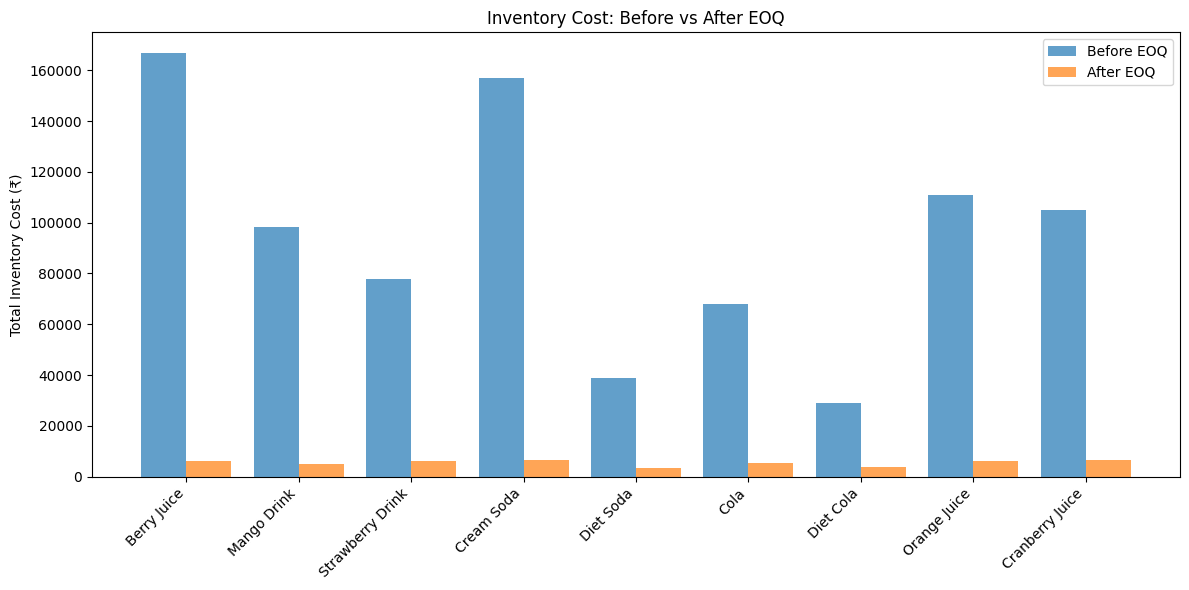

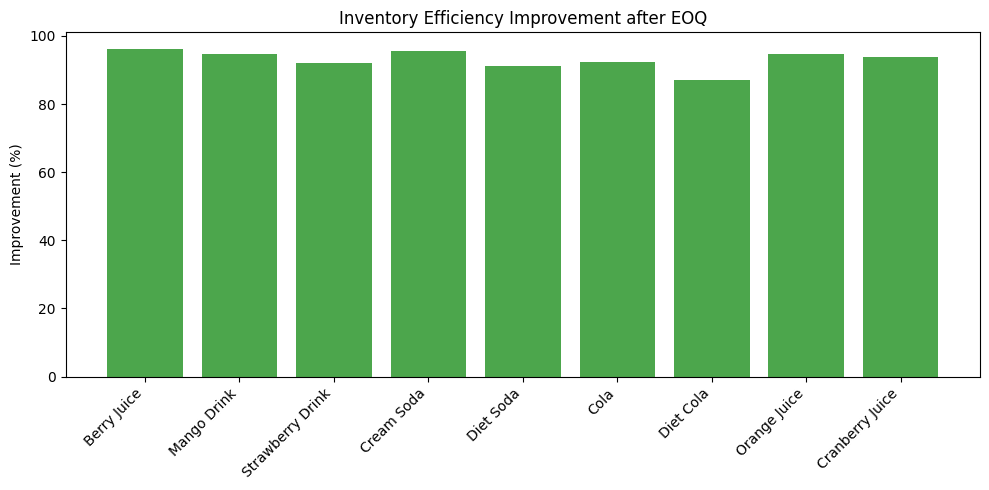

In [ ]:
import matplotlib.pyplot as plt

#  Cost Comparison Before vs After EOQ
plt.figure(figsize=(12,6))
x = range(len(data))
plt.bar(x, data['Cost_Before'], width=0.4, label='Before EOQ', alpha=0.7)
plt.bar([i+0.4 for i in x], data['Cost_After'], width=0.4, label='After EOQ', alpha=0.7)
plt.xticks([i+0.2 for i in x], data['PRODUCT_NAME'], rotation=45, ha="right")
plt.ylabel("Total Inventory Cost (₹)")
plt.title("Inventory Cost: Before vs After EOQ")
plt.legend()
plt.tight_layout()
plt.show()

#  % Improvement per Product
plt.figure(figsize=(10,5))
plt.bar(data['PRODUCT_NAME'], data['Improvement_%'], color='green', alpha=0.7)
plt.xticks(rotation=45, ha="right")
plt.ylabel("Improvement (%)")
plt.title("Inventory Efficiency Improvement after EOQ")
plt.tight_layout()
plt.show()


📊 INVENTORY OPTIMIZATION DASHBOARD 📊
Total Inventory Cost (Before EOQ): ₹850,852.36
Total Inventory Cost (After EOQ):  ₹48,752.04
💰 Total Savings: ₹802,100.32
⚡ Average Improvement: 93.14%



/tmp/ipython-input-798813555.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(data['PRODUCT_NAME'], rotation=45, ha="right")


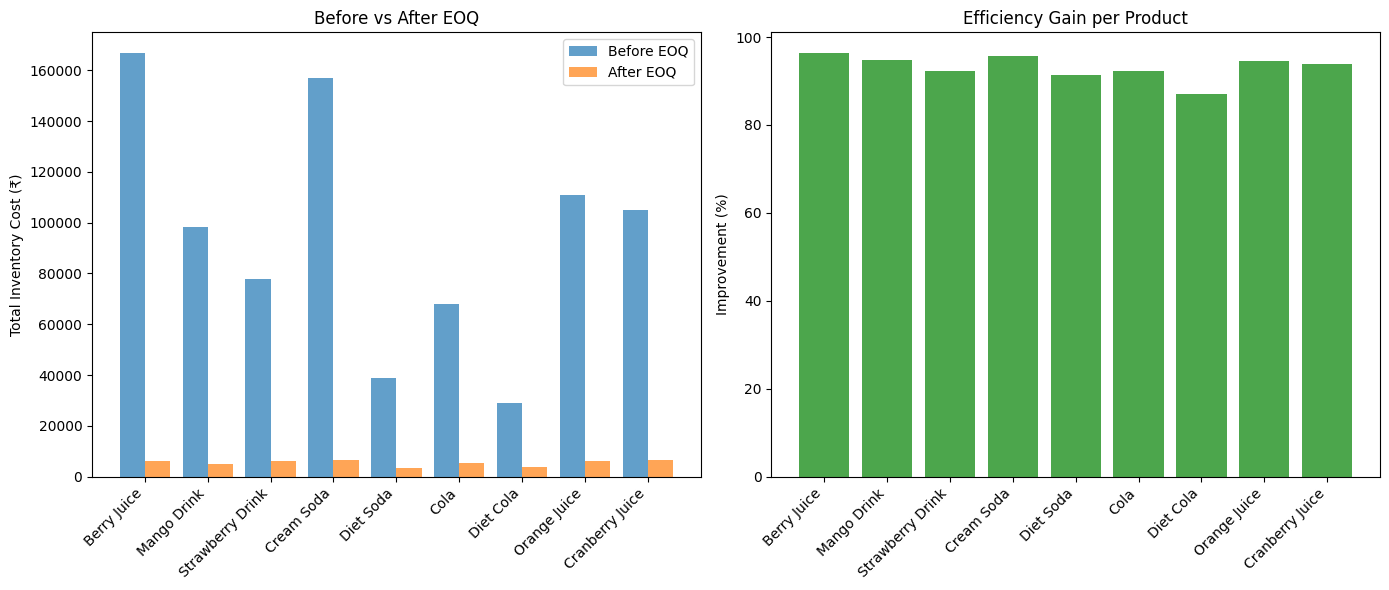

In [ ]:
import matplotlib.pyplot as plt

# ---- KPI Summary ----
total_before = data['Cost_Before'].sum()
total_after = data['Cost_After'].sum()
total_savings = total_before - total_after
avg_improvement = data['Improvement_%'].mean()

print("📊 INVENTORY OPTIMIZATION DASHBOARD 📊")
print("====================================")
print(f"Total Inventory Cost (Before EOQ): ₹{total_before:,.2f}")
print(f"Total Inventory Cost (After EOQ):  ₹{total_after:,.2f}")
print(f"💰 Total Savings: ₹{total_savings:,.2f}")
print(f"⚡ Average Improvement: {avg_improvement:.2f}%")
print("====================================\n")

# ---- Graphs ----
fig, axes = plt.subplots(1, 2, figsize=(14,6))

# 1️⃣ Cost Comparison
x = range(len(data))
axes[0].bar(x, data['Cost_Before'], width=0.4, label='Before EOQ', alpha=0.7)
axes[0].bar([i+0.4 for i in x], data['Cost_After'], width=0.4, label='After EOQ', alpha=0.7)
axes[0].set_xticks([i+0.2 for i in x])
axes[0].set_xticklabels(data['PRODUCT_NAME'], rotation=45, ha="right")
axes[0].set_ylabel("Total Inventory Cost (₹)")
axes[0].set_title("Before vs After EOQ")
axes[0].legend()

# 2️⃣ % Improvement per Product
axes[1].bar(data['PRODUCT_NAME'], data['Improvement_%'], color='green', alpha=0.7)
axes[1].set_xticklabels(data['PRODUCT_NAME'], rotation=45, ha="right")
axes[1].set_ylabel("Improvement (%)")
axes[1].set_title("Efficiency Gain per Product")

plt.tight_layout()
plt.show()
